In [97]:
import sys
import os
import math
import datetime
from tqdm import tqdm
import pandas as pd
import numpy as np
import math

import tensorflow as tf
from tensorflow import keras

from bs4 import BeautifulSoup
from bs4.element import Comment
import re
from langdetect import detect_langs
import nltk
from nltk.corpus import stopwords


from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

from process_websites import get_corpus
from my_models import categoryDetection, unify_yelp_data_classes


try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
    if sys.version_info > (3.0):
        os.system('python3 -m nltk.downloader stopwords')
    else:
        os.system('pyhton -m nltk.downloader.stopwords')
        
class style():
    BLACK = '\033[30m'
    RED = '\033[31m'
    GREEN = '\033[32m'
    YELLOW = '\033[33m'
    BLUE = '\033[34m'
    MAGENTA = '\033[35m'
    CYAN = '\033[36m'
    WHITE = '\033[37m'
    UNDERLINE = '\033[4m'
    RESET = '\033[0m'
        
FOLDER_PATH = '/home/vahidsanei_google_com/'

In [98]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
!python -m nltk.downloader stopwords

/opt/conda/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/vahidsanei_google_com/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_csv('/home/vahidsanei_google_com/data/yelp_data/updated_large/business_with_corpus.csv')
df.head()

,Unnamed: 0,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,url,webpage_text,is_eng,webpage_corpus
0,0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,10913 Bailey Rd,Cornelius,NC,28031,35.462724,-80.852612,3.5,36,1,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...","Active Life, Gun/Rifle Ranges, Guns & Ammo, Sh...","{'Monday': '10:0-18:0', 'Tuesday': '11:0-20:0'...",http://www.therangeatlakenorman.com/,"b'<!DOCTYPE html>\n<html lang=""en-US"">\n<head>...",True,Shooting Ranges Gun Rental Charlotte NC The Ra...
1,1,XNoUzKckATkOD1hP6vghZg,Felinus,3554 Rue Notre-Dame O,Montreal,QC,H4C 1P4,45.479984,-73.580070,5.0,5,1,NaN,"Pets, Pet Services, Pet Groomers",NaN,http://www.felinus.ca,"b'<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0...",False,NaN
2,2,51M2Kk903DFYI6gnB5I6SQ,USE MY GUY SERVICES LLC,4827 E Downing Cir,Mesa,AZ,85205,33.428065,-111.726648,4.5,26,1,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Home Services, Plumbing, Electricians, Handyma...","{'Monday': '0:0-0:0', 'Tuesday': '9:0-16:0', '...",https://www.usemyguyservices.com,"b'<!DOCTYPE html>\n<html lang=""en-US"" prefix=""...",True,Home Renovations and Repairs Phoenix AZ Home U...
3,3,cKyLV5oWZJ2NudWgqs8VZw,Oasis Auto Center - Gilbert,"1720 W Elliot Rd, Ste 105",Gilbert,AZ,85233,33.350399,-111.827142,4.5,38,1,{'BusinessAcceptsCreditCards': 'True'},"Auto Repair, Automotive, Oil Change Stations, ...","{'Monday': '7:0-18:0', 'Tuesday': '7:0-18:0', ...",http://oasisautocenter.net,"b'<!DOCTYPE html>\n<html lang=""en-US"" prefix=""...",True,Home Oasis Auto CenterOasis Auto Center Pages ...
4,4,ScYkbYNkDgCneBrD9vqhCQ,Junction Tire & Auto Service,6910 E Southern Ave,Mesa,AZ,85209,33.393885,-111.682226,5.0,18,1,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Auto Repair, Oil Change Stations, Automotive, ...","{'Monday': '7:30-17:0', 'Tuesday': '7:30-17:0'...",http://junctiontire.net/tires-auto-repair-mesa-az,"b'<!DOCTYPE html>\r\n<html lang=""en"">\r\n<head...",True,Contact Junction Tire Tires Auto Repair Shop i...


In [4]:
df.columns

Index(['Unnamed: 0', 'business_id', 'name', 'address', 'city', 'state',
       'postal_code', 'latitude', 'longitude', 'stars', 'review_count',
       'is_open', 'attributes', 'categories', 'hours', 'url', 'webpage_text',
       'is_eng', 'webpage_corpus'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78568 entries, 0 to 78567
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      78568 non-null  int64  
 1   business_id     78568 non-null  object 
 2   name            78568 non-null  object 
 3   address         75147 non-null  object 
 4   city            78568 non-null  object 
 5   state           78568 non-null  object 
 6   postal_code     78410 non-null  object 
 7   latitude        78568 non-null  float64
 8   longitude       78568 non-null  float64
 9   stars           78568 non-null  float64
 10  review_count    78568 non-null  int64  
 11  is_open         78568 non-null  int64  
 12  attributes      67645 non-null  object 
 13  categories      78514 non-null  object 
 14  hours           67573 non-null  object 
 15  url             78568 non-null  object 
 16  webpage_text    78568 non-null  object 
 17  is_eng          78568 non-null 

In [6]:
for url, corpus in zip(df['url'][-10:], df['webpage_corpus'][-10:]):
    try:
        print(url)
        print('#' * 50)
        print(corpus[:1000])
        print('*' * 50)
    except:
        pass

http://www.thedakotaatcamelback.com
##################################################
Sorry An error has occured No domain data found for domain wwwthedakotaatcamelbackcom 2020 RentPath LLC All rights reserved All photos videos and floor plans are the property of RentPath LLC All text is the property of this property RentPath is in no way affiliated with the management or ownership of this property
**************************************************
http://www.alyshaan.com
##################################################
https://www.kfc.ca//store/415-mount-pleasant-rd-toronto
##################################################
Be A Franais Sign in FOR SHARING FOR ONE DEALS 0 000 START MY ORDER 415 Mount Pleasant Rd Hours Sunday 1100 AM1000 PM Monday 1100 AM1000 PM Tuesday 1100 AM1000 PM Wednesday 1100 AM1000 PM Thursday 1100 AM1000 PM Friday 1100 AM1000 PM Saturday 1100 AM1000 PM 415 Mount Pleasant Rd 4164810900 Choose Another Location Store Details 415 Mount Pleasant Rd Toronto ON M4

In [7]:
df_sentsplit = pd.read_csv('/home/vahidsanei_google_com/data/yelp_data/updated_large/business_with_corpus_sent_split.csv')
df_sentsplit.head()

,Unnamed: 0,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,url,webpage_text,is_eng,webpage_corpus
0,0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,10913 Bailey Rd,Cornelius,NC,28031,35.462724,-80.852612,3.5,36,1,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...","Active Life, Gun/Rifle Ranges, Guns & Ammo, Sh...","{'Monday': '10:0-18:0', 'Tuesday': '11:0-20:0'...",http://www.therangeatlakenorman.com/,"b'<!DOCTYPE html>\n<html lang=""en-US"">\n<head>...",True,Shooting Ranges Gun Rental Charlotte NC The Ra...
1,1,XNoUzKckATkOD1hP6vghZg,Felinus,3554 Rue Notre-Dame O,Montreal,QC,H4C 1P4,45.479984,-73.580070,5.0,5,1,NaN,"Pets, Pet Services, Pet Groomers",NaN,http://www.felinus.ca,"b'<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0...",False,NaN
2,2,51M2Kk903DFYI6gnB5I6SQ,USE MY GUY SERVICES LLC,4827 E Downing Cir,Mesa,AZ,85205,33.428065,-111.726648,4.5,26,1,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Home Services, Plumbing, Electricians, Handyma...","{'Monday': '0:0-0:0', 'Tuesday': '9:0-16:0', '...",https://www.usemyguyservices.com,"b'<!DOCTYPE html>\n<html lang=""en-US"" prefix=""...",True,Home Renovations and Repairs Phoenix AZ Home U...
3,3,cKyLV5oWZJ2NudWgqs8VZw,Oasis Auto Center - Gilbert,"1720 W Elliot Rd, Ste 105",Gilbert,AZ,85233,33.350399,-111.827142,4.5,38,1,{'BusinessAcceptsCreditCards': 'True'},"Auto Repair, Automotive, Oil Change Stations, ...","{'Monday': '7:0-18:0', 'Tuesday': '7:0-18:0', ...",http://oasisautocenter.net,"b'<!DOCTYPE html>\n<html lang=""en-US"" prefix=""...",True,Home Oasis Auto CenterOasis Auto Center Pages ...
4,4,ScYkbYNkDgCneBrD9vqhCQ,Junction Tire & Auto Service,6910 E Southern Ave,Mesa,AZ,85209,33.393885,-111.682226,5.0,18,1,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Auto Repair, Oil Change Stations, Automotive, ...","{'Monday': '7:30-17:0', 'Tuesday': '7:30-17:0'...",http://junctiontire.net/tires-auto-repair-mesa-az,"b'<!DOCTYPE html>\r\n<html lang=""en"">\r\n<head...",True,Contact Junction Tire Tires Auto Repair Shop i...


In [8]:
for url, corpus in zip(df['url'][-10:], df['webpage_corpus'][-10:]):
    try:
        print(url)
        print('#' * 50)
        print(corpus[:1000])
        print('*' * 50)
    except:
        pass

http://www.thedakotaatcamelback.com
##################################################
Sorry An error has occured No domain data found for domain wwwthedakotaatcamelbackcom 2020 RentPath LLC All rights reserved All photos videos and floor plans are the property of RentPath LLC All text is the property of this property RentPath is in no way affiliated with the management or ownership of this property
**************************************************
http://www.alyshaan.com
##################################################
https://www.kfc.ca//store/415-mount-pleasant-rd-toronto
##################################################
Be A Franais Sign in FOR SHARING FOR ONE DEALS 0 000 START MY ORDER 415 Mount Pleasant Rd Hours Sunday 1100 AM1000 PM Monday 1100 AM1000 PM Tuesday 1100 AM1000 PM Wednesday 1100 AM1000 PM Thursday 1100 AM1000 PM Friday 1100 AM1000 PM Saturday 1100 AM1000 PM 415 Mount Pleasant Rd 4164810900 Choose Another Location Store Details 415 Mount Pleasant Rd Toronto ON M4

In [9]:
for url, corpus in zip(df_sentsplit['url'][-10:], df_sentsplit['webpage_corpus'][-10:]):
    try:
        print(url)
        print('#' * 50)
        print(corpus[:1000])
        print('*' * 50)
    except:
        pass

http://www.thedakotaatcamelback.com
##################################################
Sorry#An error has occured No domain data found for domain wwwthedakotaatcamelbackcom 2020 RentPath LLC#All rights reserved#All photos videos and floor plans are the property of RentPath LLC#All text is the property of this property#RentPath is in no way affiliated with the management or ownership of this property
**************************************************
http://www.alyshaan.com
##################################################
https://www.kfc.ca//store/415-mount-pleasant-rd-toronto
##################################################
Be A Franais Sign in FOR SHARING FOR ONE DEALS 0 000 START MY ORDER 415 Mount Pleasant Rd Hours Sunday 1100 AM1000 PM Monday 1100 AM1000 PM Tuesday 1100 AM1000 PM Wednesday 1100 AM1000 PM Thursday 1100 AM1000 PM Friday 1100 AM1000 PM Saturday 1100 AM1000 PM 415 Mount Pleasant Rd 4164810900 Choose Another Location Store Details 415 Mount Pleasant Rd Toronto ON M4

In [10]:
df = unify_yelp_data_classes(df)

/home/vahidsanei_google_com/advertiser-quality-from-sites/source/my_models.py:394: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['categories'] = df['categories'].apply(lambda x: re.split('[,;&]', x))
/home/vahidsanei_google_com/advertiser-quality-from-sites/source/my_models.py:407: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['categories'] = cat


In [11]:
df_sentsplit = unify_yelp_data_classes(df_sentsplit)

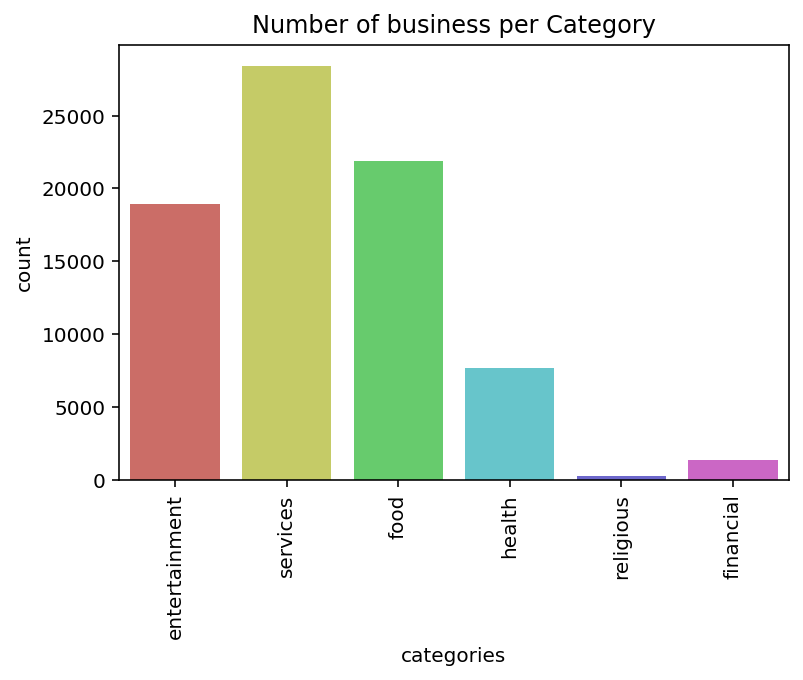

In [12]:
chart = sns.countplot(df['categories'], palette='hls')
plt.title('Number of business per Category')
chart.set_xticklabels(chart.get_xticklabels(), horizontalalignment='center', rotation=90);

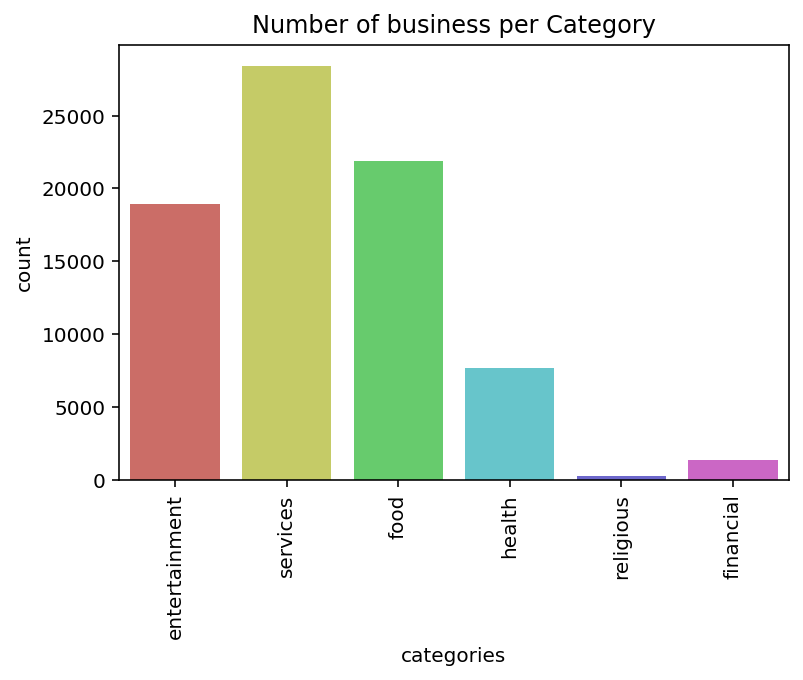

In [13]:
chart = sns.countplot(df_sentsplit['categories'], palette='hls')
plt.title('Number of business per Category')
chart.set_xticklabels(chart.get_xticklabels(), horizontalalignment='center', rotation=90);

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78483 entries, 0 to 78567
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      78483 non-null  int64  
 1   business_id     78483 non-null  object 
 2   name            78483 non-null  object 
 3   address         75067 non-null  object 
 4   city            78483 non-null  object 
 5   state           78483 non-null  object 
 6   postal_code     78326 non-null  object 
 7   latitude        78483 non-null  float64
 8   longitude       78483 non-null  float64
 9   stars           78483 non-null  float64
 10  review_count    78483 non-null  int64  
 11  is_open         78483 non-null  int64  
 12  attributes      67627 non-null  object 
 13  categories      78483 non-null  object 
 14  hours           67565 non-null  object 
 15  url             78483 non-null  object 
 16  webpage_text    78483 non-null  object 
 17  is_eng          78483 non-null 

In [15]:
folder_path = os.path.join(FOLDER_PATH, 'data','uncased_L-12_H-768_A-12')
tokenizer = FullTokenizer(vocab_file=os.path.join(folder_path, 'vocab.txt'))

bert_ckpt_file = os.path.join(folder_path, 'bert_model.ckpt')
bert_config_file = os.path.join(folder_path, 'bert_config.json')

tokens_test = tokenizer.tokenize('This is an open-source project for category detection of businesses based on their website contents!')
print(tokens_test)
print(tokenizer.convert_tokens_to_ids(tokens_test))

['this', 'is', 'an', 'open', '-', 'source', 'project', 'for', 'category', 'detection', 'of', 'businesses', 'based', 'on', 'their', 'website', 'contents', '!']
[2023, 2003, 2019, 2330, 1011, 3120, 2622, 2005, 4696, 10788, 1997, 5661, 2241, 2006, 2037, 4037, 8417, 999]


In [16]:
split_sz = int(len(df) * 0.8)
train = df[:split_sz]
test = df[split_sz:]

In [17]:
cat = categoryDetection(train, test, tokenizer, max_seq_len=300)

40760it [08:16, 82.16it/s] 
8it [00:00, 74.66it/s]

Removed 17.6864573110893% of entries, due to being short corpus length.


10107it [02:09, 78.15it/s]


Removed 17.77975660433363% of entries, due to being short corpus length.


In [18]:
set(df['categories'])

{'entertainment', 'financial', 'food', 'health', 'religious', 'services'}

In [19]:
model = cat.build_model(bert_config_file, bert_ckpt_file, max_seq_len=300)

loader: No value for:[bert/encoder/layer_0/attention/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-down/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert/encoder/layer_0/attention/output/adapter-down/bias:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-down/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert/encoder/layer_0/attention/output/adapter-up/kernel:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-up/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert/encoder/layer_0/attention/output/adapter-up/bias:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-up/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert/encoder/layer_0/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer_0/output/

loader: No value for:[bert/encoder/layer_5/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer_5/output/adapter-down/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert/encoder/layer_5/output/adapter-down/bias:0], i.e.:[bert/encoder/layer_5/output/adapter-down/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert/encoder/layer_5/output/adapter-up/kernel:0], i.e.:[bert/encoder/layer_5/output/adapter-up/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert/encoder/layer_5/output/adapter-up/bias:0], i.e.:[bert/encoder/layer_5/output/adapter-up/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert/encoder/layer_6/attention/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer_6/attention/output/adapter-down/kernel] in:[/home/vahidsanei_google_com/data/un

loader: No value for:[bert/encoder/layer_11/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer_11/output/adapter-down/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert/encoder/layer_11/output/adapter-down/bias:0], i.e.:[bert/encoder/layer_11/output/adapter-down/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert/encoder/layer_11/output/adapter-up/kernel:0], i.e.:[bert/encoder/layer_11/output/adapter-up/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert/encoder/layer_11/output/adapter-up/bias:0], i.e.:[bert/encoder/layer_11/output/adapter-up/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
Done loading 196 BERT weights from: /home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f4bfd5b0f10> (prefix:bert)

In [21]:
cat.compile_model(model, cat.train_x, cat.train_y)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 300)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 300, 768)          111269376 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 800)               615200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 800)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 800)               640800

In [22]:
model.evaluate(cat.test_x, cat.test_y);

260/260 [==============================] - 67s 258ms/step - loss: 1.1845 - acc: 0.8588


In [23]:
def testing(text, trained_model, cat:categoryDetection, LEN=300):
    tokens = tokenizer.tokenize(text)
    ids = tokenizer.convert_tokens_to_ids(tokens)
    ids = ids + [0 for _ in range(LEN  - len(ids))]
    ids = ids[:LEN]
    y_pred = trained_model.predict([ids])
    print(cat.classes[np.argmax(y_pred)])
    print(y_pred)

In [24]:
text = 'Restaurants are classified or distinguished in many different ways. The primary factors are usually the food itself (e.g. vegetarian, seafood, steak); the cuisine (e.g. Italian, Chinese, Japanese, Indian, French, Mexican, Thai) or the style of offering (e.g. tapas bar, a sushi train, a tastet restaurant, a buffet restaurant or a yum cha restaurant). Beyond this, restaurants may differentiate themselves on factors including speed (see fast food), formality, location, cost, service, or novelty themes (such as automated restaurants). Some of these include fine dining, casual dining, contemporary casual, family style, fast casual, fast food, cafes, buffet, concession stands, food trucks, pop-up restaurants, and ghost restaurants. Restaurants range from inexpensive and informal lunching or dining places catering to people working nearby, with modest food served in simple settings at low prices, to expensive establishments serving refined food and fine wines in a formal setting. In the former case, customers usually wear casual clothing. In the latter case, depending on culture and local traditions, customers might wear semi-casual, semi-formal or formal wear. Typically, at mid- to high-priced restaurants, customers sit at tables, their orders are taken by a waiter, who brings the food when it is ready. After eating, the customers then pay the bill. In some restaurants, such as workplace cafeterias, there are no waiters; the customers use trays, on which they place cold items that they select from a refrigerated container and hot items which they request from cooks, and then they pay a cashier before they sit down. Another restaurant approach which uses few waiters is the buffet restaurant. Customers serve food onto their own plates and then pay at the end of the meal. Buffet restaurants typically still have waiters to serve drinks and alcoholic beverages. Fast food restaurants are also considered a restaurant. In addition, food trucks are another popular option for people who want quick food service. Tourists around the world can enjoy dining services on railway cars and cruise ships dining rooms, which are essentially traveling restaurants. Many railways dining services cater to the needs of travelers by providing railway refreshment rooms at railway stations. The fondness for such refreshment rooms, however, may be purely cultural as not one refreshing crumb of them has ever been witnessed in the United States. In the 2000s, a number of traveling restaurants, specifically designed for tourists, had been created. These can be found on trams, boats, buses, etc. Unfortunately, in 2020 little evidence remains of them in the United States. Many cruise ships provide a variety of dining experiences including a main restaurant, satellites restaurants, room service, specialty restaurants, cafes, bars, and buffets to name a few. Some restaurants on these cruise ships required reservations and specific dress codes.'
testing(text, model, cat)

food
[[4.6850127e-01 3.0693039e-04 5.3012592e-01 8.9235626e-05 8.4356929e-04
  1.3303947e-04]]


In [25]:
text = 'An auto mechanic (automotive technician in most of North America, light vehicle technician in British English, and motor mechanic in Australian English) is a mechanic with a variety of automobile makes or either in a specific area or in a specific make of automobile. In repairing cars, their main role is to diagnose the problem accurately and quickly. They often have to quote prices for their customers before commencing work or after partial disassembly for inspection. Their job may involve the repair of a specific part or the replacement of one or more parts as assemblies. Basic vehicle maintenance is a fundamental part of a mechanic\'s work in modern industrialized countries while in others they are only consulted when a vehicle is already showing signs of malfunction. Preventive maintenance is also a fundamental part of a mechanic\'s job, but this is not possible in the case of vehicles that are not regularly maintained by a mechanic. One misunderstood aspect of preventive maintenance is scheduled replacement of various parts, which occurs before failure to avoid far more expensive damage. Because this means that parts are replaced before any problem is observed, many vehicle owners will not understand why the expense is necessary. With the rapid advancement in technology, the mechanics job has evolved from purely mechanical, to include electronic technology. Because vehicles today possess complex computer and electronic systems, mechanics need to have a broader base of knowledge than in the past.'
testing(text, model, cat)

services
[[1.0345219e-07 1.2455270e-07 1.0339320e-11 7.1932321e-11 1.1053221e-09
  9.9999976e-01]]


In [99]:
split_sz = int(len(df_sentsplit) * 0.8)
train = df_sentsplit[:split_sz]
test = df_sentsplit[split_sz:]

In [100]:
glove_address = os.path.join(FOLDER_PATH, 'data', 'glove_data', 'glove.6B.300d.txt')
cat2 = categoryDetection(train, test, tokenizer, max_seq_len=300, glove_embeddings_address=glove_address, glove_sentence_similarity=True)

40763it [1:18:13,  8.68it/s]
0it [00:00, ?it/s]

Removed 17.66553001496455% of entries, due to being short corpus length.


10076it [19:05,  8.79it/s]


Removed 17.96347757046447% of entries, due to being short corpus length.


In [101]:
model2 = cat2.build_model(bert_config_file, bert_ckpt_file, max_seq_len=300)

loader: No value for:[bert_4/encoder/layer_0/attention/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-down/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_4/encoder/layer_0/attention/output/adapter-down/bias:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-down/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_4/encoder/layer_0/attention/output/adapter-up/kernel:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-up/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_4/encoder/layer_0/attention/output/adapter-up/bias:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-up/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_4/encoder/layer_0/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer

loader: No value for:[bert_4/encoder/layer_8/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer_8/output/adapter-down/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_4/encoder/layer_8/output/adapter-down/bias:0], i.e.:[bert/encoder/layer_8/output/adapter-down/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_4/encoder/layer_8/output/adapter-up/kernel:0], i.e.:[bert/encoder/layer_8/output/adapter-up/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_4/encoder/layer_8/output/adapter-up/bias:0], i.e.:[bert/encoder/layer_8/output/adapter-up/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_4/encoder/layer_9/attention/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer_9/attention/output/adapter-down/kernel] in:[/home/vahidsanei_google_c

In [102]:
cat2.compile_model(model2, cat2.train_x, cat2.train_y)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 300)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 300, 768)          111269376 
_________________________________________________________________
lambda_4 (Lambda)            (None, 768)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 768)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 800)               615200    
_________________________________________________________________
dropout_12 (Dropout)         (None, 800)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 800)               6408

In [103]:
model2.evaluate(cat2.test_x, cat2.test_y);

259/259 [==============================] - 67s 260ms/step - loss: 1.1927 - acc: 0.8495


In [104]:
text = 'Restaurants are classified or distinguished in many different ways. The primary factors are usually the food itself (e.g. vegetarian, seafood, steak); the cuisine (e.g. Italian, Chinese, Japanese, Indian, French, Mexican, Thai) or the style of offering (e.g. tapas bar, a sushi train, a tastet restaurant, a buffet restaurant or a yum cha restaurant). Beyond this, restaurants may differentiate themselves on factors including speed (see fast food), formality, location, cost, service, or novelty themes (such as automated restaurants). Some of these include fine dining, casual dining, contemporary casual, family style, fast casual, fast food, cafes, buffet, concession stands, food trucks, pop-up restaurants, and ghost restaurants. Restaurants range from inexpensive and informal lunching or dining places catering to people working nearby, with modest food served in simple settings at low prices, to expensive establishments serving refined food and fine wines in a formal setting. In the former case, customers usually wear casual clothing. In the latter case, depending on culture and local traditions, customers might wear semi-casual, semi-formal or formal wear. Typically, at mid- to high-priced restaurants, customers sit at tables, their orders are taken by a waiter, who brings the food when it is ready. After eating, the customers then pay the bill. In some restaurants, such as workplace cafeterias, there are no waiters; the customers use trays, on which they place cold items that they select from a refrigerated container and hot items which they request from cooks, and then they pay a cashier before they sit down. Another restaurant approach which uses few waiters is the buffet restaurant. Customers serve food onto their own plates and then pay at the end of the meal. Buffet restaurants typically still have waiters to serve drinks and alcoholic beverages. Fast food restaurants are also considered a restaurant. In addition, food trucks are another popular option for people who want quick food service. Tourists around the world can enjoy dining services on railway cars and cruise ships dining rooms, which are essentially traveling restaurants. Many railways dining services cater to the needs of travelers by providing railway refreshment rooms at railway stations. The fondness for such refreshment rooms, however, may be purely cultural as not one refreshing crumb of them has ever been witnessed in the United States. In the 2000s, a number of traveling restaurants, specifically designed for tourists, had been created. These can be found on trams, boats, buses, etc. Unfortunately, in 2020 little evidence remains of them in the United States. Many cruise ships provide a variety of dining experiences including a main restaurant, satellites restaurants, room service, specialty restaurants, cafes, bars, and buffets to name a few. Some restaurants on these cruise ships required reservations and specific dress codes.'
testing(text, model2, cat2)

food
[[2.4973382e-03 1.6059013e-06 9.9744654e-01 6.6401017e-06 3.4991630e-05
  1.2929605e-05]]


In [105]:
text = 'An auto mechanic (automotive technician in most of North America, light vehicle technician in British English, and motor mechanic in Australian English) is a mechanic with a variety of automobile makes or either in a specific area or in a specific make of automobile. In repairing cars, their main role is to diagnose the problem accurately and quickly. They often have to quote prices for their customers before commencing work or after partial disassembly for inspection. Their job may involve the repair of a specific part or the replacement of one or more parts as assemblies. Basic vehicle maintenance is a fundamental part of a mechanic\'s work in modern industrialized countries while in others they are only consulted when a vehicle is already showing signs of malfunction. Preventive maintenance is also a fundamental part of a mechanic\'s job, but this is not possible in the case of vehicles that are not regularly maintained by a mechanic. One misunderstood aspect of preventive maintenance is scheduled replacement of various parts, which occurs before failure to avoid far more expensive damage. Because this means that parts are replaced before any problem is observed, many vehicle owners will not understand why the expense is necessary. With the rapid advancement in technology, the mechanics job has evolved from purely mechanical, to include electronic technology. Because vehicles today possess complex computer and electronic systems, mechanics need to have a broader base of knowledge than in the past.'
testing(text, model2, cat2)

services
[[4.1248645e-06 2.3946009e-06 6.3382322e-09 1.4190827e-08 3.1064392e-08
  9.9999344e-01]]


In [33]:
cat3 = categoryDetection(train, test, tokenizer, max_seq_len=300, bert_sentence_similarity=True, bert_ckpt_file=bert_ckpt_file, bert_config_file=bert_config_file)

Preparing data for the pretraining step ...


40763it [08:56, 76.00it/s] 


loader: No value for:[bert_2/encoder/layer_0/attention/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-down/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_2/encoder/layer_0/attention/output/adapter-down/bias:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-down/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_2/encoder/layer_0/attention/output/adapter-up/kernel:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-up/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_2/encoder/layer_0/attention/output/adapter-up/bias:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-up/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_2/encoder/layer_0/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer

loader: No value for:[bert_2/encoder/layer_7/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer_7/output/adapter-down/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_2/encoder/layer_7/output/adapter-down/bias:0], i.e.:[bert/encoder/layer_7/output/adapter-down/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_2/encoder/layer_7/output/adapter-up/kernel:0], i.e.:[bert/encoder/layer_7/output/adapter-up/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_2/encoder/layer_7/output/adapter-up/bias:0], i.e.:[bert/encoder/layer_7/output/adapter-up/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_2/encoder/layer_8/attention/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer_8/attention/output/adapter-down/kernel] in:[/home/vahidsanei_google_c

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 50)]              0         
_________________________________________________________________
bert (BertModelLayer)        (None, 50, 768)           111269376 
_________________________________________________________________
lambda_2 (Lambda)            (None, 768)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 800)               615200    
_________________________________________________________________
dropout_7 (Dropout)          (None, 800)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 4806

2it [00:11,  5.63s/it]

Home Oasis Auto CenterOasis Auto Center Pages Navigation Menu Home Services Coupons Testimonials Contact Us Welcome to Oasis Auto Center#Thank you for taking the time to visit our website#Oasis Auto Center is a familyownedandoperated fullservice automotive repair and maintenance shop#With locations in both Tempe AZ and Gilbert AZ we have been servicing the east valley for over 20 years#About Us Request Appointment#Request Appointment now#Request Appointment Our Technicians Are ASE Certified#We are dedicated to providing you with the best quality repair to your vehicle#Our Services We have 2 locations to best serve you#In Tempe AZ and Gilbert AZ#Please Contact Us Now#Contact Us Sure Critic Reviews No Appointment Required#Our Address 1835 E Guadalupe Rd Tempe AZ 85283 480 4912022 Monday Friday 7 am 6 pm Saturday 7 am 3 pm Our Second Location 1720 W Elliot Rd#Ste 105 Gilbert AZ 85233 480 7771042 Auto Service News Check out our Automotive News Page#Social Links Payments Visa MasterCard Dis

3it [00:12,  4.23s/it]

Oasis Auto Center is a familyownedandoperated fullservice automotive repair and maintenance shop Request Appointment Our Technicians Are ASE Certified We are dedicated to providing you with the best quality repair to your vehicle Contact Us Sure Critic Reviews No Appointment Required Ste 105 Gilbert AZ 85233 480 7771042 Auto Service News Check out our Automotive News Page Home Oasis Auto CenterOasis Auto Center Pages Navigation Menu Home Services Coupons Testimonials Contact Us Welcome to Oasis Auto Center Our Services We have 2 locations to best serve you Please Contact Us Now In Tempe AZ and Gilbert AZ Thank you for taking the time to visit our website Social Links Payments Visa MasterCard Discover American Express Our Affiliations xc2xa92014 Mitchell1 Our Address 1835 E Guadalupe Rd Tempe AZ 85283 480 4912022 Monday Friday 7 am 6 pm Saturday 7 am 3 pm Our Second Location 1720 W Elliot Rd With locations in both Tempe AZ and Gilbert AZ we have been servicing the east valley for over 2

20it [00:41,  1.28s/it]

Bath Body Works SemiAnnual Sale xe2x80x93 Body Care Home Fragrances 0 Sign In or Sign Up Sign In or Sign Up Order Tracking My LoveIt List Search Catalog Search cancel Menu Search Catalog Search cancel Body Care FEATURED New Body Care Customer Favorites Retired Fragrances Travel Size BATH SHOWER Body Wash Shower Gel Bubble Bath Body Scrub MOISTURIZERS Body Lotion Body Cream Body Massage Oils Hand Cream Shave Lip Gloss Balms FRAGRANCE Body Sprays Mists Perfume Cologne COLLECTIONS Perfect Peony Into the Night Gingham Aromatherapy Body Care Mens Body Care Body Care Offers Top Offers 5 Select Body Care 50 Off Select Body Care Buy 3 Get 2 Free Select Body Care Buy 2 Get 1 Free Trial Size Explore Body Care Close dropdown Hand Soaps FEATURED New Hand Soaps Hand Care HAND SOAPS All Hand Soaps Foaming Soaps Gel Soaps Deep Cleansing Nourishing Soaps Soap Holders HAND SANITIZERS All Hand Sanitizers Hand Soaps Offers Top Offers 626 or 420 Hand Soaps 50 Off Select Hand Soaps Explore Hand Soaps Close

21it [00:42,  1.42s/it]

Bath Body Works SemiAnnual Sale xe2x80x93 Body Care Home Fragrances 0 Sign In or Sign Up Sign In or Sign Up Order Tracking My LoveIt List Search Catalog Search cancel Menu Search Catalog Search cancel Body Care FEATURED New Body Care Customer Favorites Retired Fragrances Travel Size BATH SHOWER Body Wash Shower Gel Bubble Bath Body Scrub MOISTURIZERS Body Lotion Body Cream Body Massage Oils Hand Cream Shave Lip Gloss Balms FRAGRANCE Body Sprays Mists Perfume Cologne COLLECTIONS Perfect Peony Into the Night Gingham Aromatherapy Body Care Mens Body Care Body Care Offers Top Offers 5 Select Body Care 50 Off Select Body Care Buy 3 Get 2 Free Select Body Care Buy 2 Get 1 Free Trial Size Explore Body Care Close dropdown Hand Soaps FEATURED New Hand Soaps Hand Care HAND SOAPS All Hand Soaps Foaming Soaps Gel Soaps Deep Cleansing Nourishing Soaps Soap Holders HAND SANITIZERS All Hand Sanitizers Hand Soaps Offers Top Offers 626 or 420 Hand Soaps 50 Off Select Hand Soaps Explore Hand Soaps Close

39it [01:11,  1.37s/it]

TruGreen#Live Life outside#Call now for a free quote 8442612466 Call now for a free quote 8442612466 Manage My Account Commercial Services TAP TO CALL 8442612466 Welcome#Tell us what brings you to TruGreen today#Beautiful city Lawns Start Here#Sign up Today and Get 50 Off Your First Service My home is located in the area#Next What is your yards biggest problem#My yard is having problems with select all that apply Weeds Trees Shrubs Brown spots Bare patches Mosquito Control Other or not sure Next Step 2 of 3 Your lawn wont be a problem much longer#Let us tailor a plan for you#Select all that apply I am ready to love my lawn#Please send me a quote for my lawn located at ex 1234 Green St#You can reach me at ex 2223334444 or drop me a line at#Just ask for#By providing my personal information including phone number and clicking See My Results I consent to 1 receive email messages for lawn tips and tricks and limited offers autodialed calls texts and prerecorded messages from TruGreen regard

40it [01:14,  1.84s/it]

Call now for a free quote 8442612466 Call now for a free quote 8442612466 Manage My Account Commercial Services TAP TO CALL 8442612466 Welcome My yard is having problems with select all that apply Weeds Trees Shrubs Brown spots Bare patches Mosquito Control Other or not sure Next Step 2 of 3 Your lawn wont be a problem much longer Select all that apply I am ready to love my lawn Please send me a quote for my lawn located at ex 1234 Green St Scroll through our gallery of photos taken by actual TruGreen specialists and see what a tailored plan can do for your lawn They are quick and efficient and leave me with a very green and healthy yard John J William S May 2019 Technicians are always very friendly and helpful Valid at participating TruGreen locations Pricing based on an average annual lawn plan cost average of 500 per year and 5000squarefoot lawn Americaxe2x80x99s 1 lawn care company based on US market share of professional lawn care companies Americas 1 lawn care company based on US

46it [01:18,  1.41it/s]

Viking Cleaners Viking Textile Restoration Dry Cleaning Dry Cleaners Phoenix 85018 Delivery NARD Services Dry Cleaning Laundry Bridal Speciality Household Items Alterations Repairs Pickup Delivery Restoration Textile Restoration Salvation Army Program Restoration FAQ About Us About Us Hours Locations Price List FAQs Employment Contact Viking Cleaners Services Dry Cleaning Laundry Bridal Speciality Household Items Alterations Repairs Pickup Delivery Restoration Textile Restoration Salvation Army Program Restoration FAQ About Us About Us Hours Locations Price List FAQs Employment Contact The Mark of Quality#We Are Open for Business Following Governor Duceyxe2x80x99s updated Covid19 stayathome orders announced on June 29th we continue to remain open to provide essential services to our customers#Our drivethrough is currently open MondayFriday 7 am 7 pm and Saturday 8 am 4 pm#Contactless drop off through our drivethrough is available#Itxe2x80x99s as easy as 1 Enter your code to open the dr

48it [01:20,  1.33it/s]

Premium Service Viking Cleaners has had the honor of servicing the Phoenix valley for over 5o years Family owned and operated we are a full service facility offering dry cleaning laundry alterations rugs leathers households drapes and bridal dry cleaning and laundry services New Customers Request a Pickup Existing customers Amenities Convenience Drivethru 247 drop off At Viking Cleaners we understand the importance of ease and convenience during your busy day Alterations Repairs Dedicated inhouse Tailor Along with offering fullservice dry cleaning and laundry Viking Cleaners also has a dedicated inhouse tailor for your alteration and repair needs Quality Reliability Premium garment care With Viking Cleaners you can be assured you receive high quality services on your clothes Back to Top Services Dry Cleaning Laundry Bridal Speciality Household Items Alterations Repairs Pickup Delivery Restoration About Us Price List Hours Locations FAQs Contact Us Viking Cleaners Viking Textile Restora

57it [01:23,  2.79it/s]

Tim Hortons You need to enable JavaScript to run this app#Tim Hortons Logo Log In Bag Icon Shopping cart preview 0 Items How would you like to receive this order#Change xe2x80x8b Mobile Nav Logo Home Coffee Cup Order Tim Hortons Barcode Icon Scan Refresh Recent More
****************************************************************************************************
Tim Hortons You need to enable JavaScript to run this app Tim Hortons Logo Log In Bag Icon Shopping cart preview 0 Items How would you like to receive this order Change xe2x80x8b Mobile Nav Logo Home Coffee Cup Order Tim Hortons Barcode Icon Scan Refresh Recent More
####################################################################################################
####################################################################################################


40763it [17:25:24,  1.54s/it]
0it [00:00, ?it/s]

Removed 17.66553001496455% of entries, due to being short corpus length.


10076it [4:26:30,  1.59s/it]


Removed 17.96347757046447% of entries, due to being short corpus length.


In [34]:
model3 = cat3.build_model(bert_config_file, bert_ckpt_file, max_seq_len=300)

loader: No value for:[bert_3/encoder/layer_0/attention/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-down/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_3/encoder/layer_0/attention/output/adapter-down/bias:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-down/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_3/encoder/layer_0/attention/output/adapter-up/kernel:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-up/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_3/encoder/layer_0/attention/output/adapter-up/bias:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-up/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_3/encoder/layer_0/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer

loader: No value for:[bert_3/encoder/layer_8/attention/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer_8/attention/output/adapter-down/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_3/encoder/layer_8/attention/output/adapter-down/bias:0], i.e.:[bert/encoder/layer_8/attention/output/adapter-down/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_3/encoder/layer_8/attention/output/adapter-up/kernel:0], i.e.:[bert/encoder/layer_8/attention/output/adapter-up/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_3/encoder/layer_8/attention/output/adapter-up/bias:0], i.e.:[bert/encoder/layer_8/attention/output/adapter-up/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_3/encoder/layer_8/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer

In [35]:
cat3.compile_model(model3, cat3.train_x, cat3.train_y)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 300)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 300, 768)          111269376 
_________________________________________________________________
lambda_3 (Lambda)            (None, 768)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 800)               615200    
_________________________________________________________________
dropout_9 (Dropout)          (None, 800)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 800)               6408

In [36]:
model3.evaluate(cat3.test_x, cat3.test_y);

259/259 [==============================] - 67s 260ms/step - loss: 1.1875 - acc: 0.8552


In [90]:
def find_wrongs(cat: categoryDetection, model, count=20):
    cnt = 0
    for ids, label in zip(cat.test_x, cat.test_y):
        if cnt == count:
            break
        y_pred = np.argmax(model.predict(np.asarray([ids])))
        if y_pred != label:
            corpus = tokenizer.convert_ids_to_tokens(ids)
            print(' '.join(corpus), '\n', f'{style.GREEN}label = {cat.classes[label]} {style.RED}predicted = {cat.classes[y_pred]}{style.RESET}')
            print('*' * 100)
            cnt += 1

In [91]:
find_wrongs(cat, model)

[CLS] sam ##s club membership get the most out of your membership sam ##s club membership more than pays for itself with exclusive savings on the things you need the things you love and all sorts of unexpected things already a member renew now select plus select club best value plus membership become a plus member club membership earn cash rewards get back on qualifying purchases up to ##year see terms included free shipping every day no minimum purchase exclusion ##s apply see details included early shopping get in before the crowds as early as am mon sat included instant savings extra offers on top of already low members ##on ##ly prices see terms included included sam ##s club master ##card eligible to earn back on gas on dining and travel and on other purchases up to per year see terms included included pay less at the pump get member ##ex ##clusive prices on fuel available in select locations included included free select prescription ##s plus over more for or less and up to off s

[CLS] happy dog cleveland hot dogs beer and lots of live music skip to content call facebook ins ##tagram ye ##lp cleveland ##s neighborhood corner bar detroit ave cleveland oh home good food parties live music about contact gift cards home ad ##min ##t happy dog is currently closed due to the corona ##virus pan ##de ##mic we hope to return as soon as possible in the meantime please check our f ##b page for ongoing ##x ##c ##xa ##up ##dates thank you the happy dog is a neighborhood corner bar in the best sense of the term we ##ve got hot dogs and beer and lots of live music from rock and country to punk and polka the bartender ##s are friendly and the bar itself is open and inviting a racetrack oval wood bar with plenty of old chrome bars ##to ##ols its not retro because its pretty much unchanged from the time the soc ##ot ##ch family built the place back in the late ##s learn more happy dog cleveland detroit ave cleveland oh kitchen hours monday x ##e ##x ##x wednesday pm x ##e ##x ##

[CLS] hour wal ##gree ##ns pharmacy morrison b ##l ##vd charlotte nc skip to main content days of no beauty deals get today ##s deal home search by key ##word or item closing suggestion find a store prescription ##s ref ##ill ##s order status records transfer request new auto ref ##ill ##s drug info more pharmacy services x ##e ##x ##x ##ba pharmacy chat ref ##ill with r ##x number home delivery pharmacy specialty pharmacy easy r ##x delivery medication compound ##ing medication flavor ##ing ne ##bu ##lizer services prescription savings club settings x ##e ##x ##x ##ba emails notification ##s express ##pa ##y make a payment family prescription ##s insurance cap preference label preferences health history your account find care find the right care right when you need it health services for conditions in ##person and online visits no appointment needed find care near you more services find care near you ins ##tore clinics flu shots im ##mun ##izations balance rewards for healthy choices 

[CLS] beauty store services in calgary sep ##hora chin ##ook centre re ##ord ##er track order find a store book a reservation search good evening x ##f ##x ##f ##x ##c ##x beauty insider join now shop rewards bazaar community profile join now purchase history track orders account settings sep ##hora credit card program apply now reservations flash color iq beauty traits beauty advisor recommendations loves list your basket is empty sign in to see items you may have added previously sign in see samples rewards and promotions in basket shop new brands gifts sale quiz ##zes community main my reservations find a sep ##hora happening at sep ##hora find a sep ##hora sep ##hora chin ##ook centre macleod trail sw calgary ab t ##h ##k ca get directions hours open today until ##pm mon fr ##i ##am ##pm sat sun ##pm ##pm for the health and safety of our clients and associates store hours may vary call your local store for operating hours [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

In [106]:
find_wrongs(cat2, model2)

[CLS] free shipping is available for online items only you can shop online without a membership card but you may miss out on members ##on ##ly pricing and pay a service fee on some items you can also manage your membership and check in for your pickup orders all with a tap travel savings access exclusive discount ##s on movie tickets major shows and events and theme parks in all of the hottest destinations our optical center pharmacy and cafe are all open to the public some items may have shipping included sam ##s club reserves the right to make changes to these terms and conditions at any time sam ##s club membership more than pays for itself with exclusive savings on the things you need the things you love and all sorts of unexpected things you ##ll also save on rental cars and hotels pharmacy savings manage and ref ##ill prescription ##s for the whole family including pets free shipping is limited to ground shipping limited items are available for free shipping to military ap ##of #

[CLS] from out of town my ##cha ##rt need help call for additional assistance cleveland ##cl ##ini ##cor ##g find a doctor locations directions patients visitors health library institutes departments appointments access home find a location directions akron general health and wellness center st ##ow medical office building st ##ow allen rd st ##ow ohio call driving directions home ##page hours of operation hours of operation facility emergency services imaging sunday closed monday am pm tuesday am pm wednesday am pm thursday am pm friday am pm saturday am noon laboratory sunday closed monday am pm tuesday am pm wednesday am pm thursday am pm friday am pm saturday am am ma ##mm ##ography appointment needed sunday closed monday am pm tuesday am pm wednesday am pm thursday am pm friday am pm saturday am noon please call for days available sports and or ##th ##o injury care sunday closed monday am pm tuesday am pm wednesday am pm thursday am pm friday am pm saturday closed special ##ties s

[CLS] your health care provider will need to call the pharmacy for the fa ##x number flavor ##ing masks unpleasant tastes and can help children take their medicine find everything you wanted to know about this store yes find everything you wanted to know about this store learn more for about prescription flavour ##ing it will open a new tab not all prescription ##s can be flavor ##ed ask your local wal ##gree ##ns pharmacy team for more details coup ##ons now you can save even more with coup ##ons that clip straight to your balance ##x ##c ##xa ##e rewards card learn more for medication disposal it will open a new tab ask about prescription flavor ##ing our prescription flavor ##ing service flavor ##x is available for at all wal ##gree ##ns and duane read ##e ph ##arm ##acies va ##cci ##nation ##s schedule an appointment or walk in flu pneumonia td ##ap see all va ##cci ##nation ##s at this store opens a simulated over ##lay other pharmacy services feel more like you cancer service fee

[CLS] inform your health care provider of any complementary therapeutic approaches you are planning to use to treat an existing or persistent condition x ##e ##x ##xa ##you are sick or have respiratory symptoms such as cough or short ##ness of breath also contact your health care provider we advise all pregnant clients to consult their treating doctor or healthcare provider before booking a pre ##nat ##al massage to implement social di ##stan ##cing we ask that all clients come alone for their appointment and bring in as few items as possible you should stay home if x ##e ##x ##xa ##you have been told by a health care professional to self ##qua ##rant ##ine x ##e ##x ##xa ##you believe you have been exposed to the virus even if you are not showing any symptoms these guidelines are based on principles of hygiene common sense and consensus guidance massage therapy is not merely a luxury but can actually function as an important part of a comprehensive therapeutic treatment plan in ##qui 

In [93]:
find_wrongs(cat3, model3)

[CLS] free shipping sam ##s club plus members with an active membership shipping to the contiguous us receive free shipping on all eligible online items denoted by a free shipping tag free shipping for plus members is not available for drop ship res ##eller ##s you can also manage your membership and check in for your pickup orders all with a tap travel savings access exclusive discount ##s on movie tickets major shows and events and theme parks in all of the hottest destinations club members can add up to at this exclusive price and plus members can add up to these members will enjoy all the per ##ks that a ##cl ##ub membership includes renew now select plus select club best value plus membership become a plus member club membership earn cash rewards get back on qualifying purchases up to ##year exclusion ##s apply see details included early shopping get in before the crowds as early as am mon sat included instant savings extra offers on top of already low members ##on ##ly prices see

[CLS] news events ma ##mm ##og ##ram screenings near you in july august posted tuesday june at ##pm by mm ##ilde metro ##hea ##lth and discount drug mart are making it easy for you to receive ax ##c ##xa ##pre ##vent ##ative ma ##mm ##og ##ram at metro ##hea ##lth ##x ##e ##x ##x ##s ma ##mm ##ography coach more coloring corner posted monday march at ##pm by mm ##ilde looking for something to help pass the time with the kids being home coloring is a great outlet for kids more metro ##hea ##lth walk ##in clinic posted thursday march at ##am by mm ##ilde clinic update the clinic at our independence location br ##eck ##sville rd medical equipment services we are caring people for caring people all rights reserved discount drug mart store lo ##cat ##or weekly ads choose your search criteria all departments products medical equipment supplies close ##outs health needs beauty products food beverage ##non alcoholic household domestic ##so ##ft goods variety ##sund ##ries books ##pet ##s elect

[CLS] hair care sham ##poo condition ##er salon hair care wavy curly coil ##y shop hair care sale on hair care more facial skin care moist ##uri ##zers natural organic skin care skin care for men shop facial skin care sale on facial skin care more sun care suns ##creen for body suns ##creen for face suns ##creen for children shop sun care sale on sun care more fragrance women ##s fragrance men ##s fragrance gift sets shop fragrance sale on fragrance more bath body body cleansing body moist ##uri ##zer hand moist ##uri ##zer shop bath body sale on bath body more birch ##box at wal ##gree ##ns beauty gift sets nails accessories and clothing for men natural organic beauty shop beauty sale on beauty new beauty beauty supplements weekly deals on beauty luxury beauty store no beauty store soap glory beauty store personal care hair care sham ##poo condition ##er salon hair care wavy curly coil ##y shop hair care sale on hair care more inc ##ont ##inen ##ce pads liner ##s protective underwear 

[CLS] storage units in phoenix az at e green ##way p ##k ##wy extra space storage find storage storage types self storage vehicle storage rv storage car storage boat storage business storage climate controlled support contact us size guide self storage tips self storage fa ##q packing supplies moving guides company info about us employment investor relations party management self storage blog my account sign in update account pay bill customer sign in search home find self storage arizona phoenix e green ##way p ##k ##wy find the right storage search other locations near you why i chose extra space storage watch the video the extra space storage difference size we offer a rights ##ize guarantee you can change your selected size at the facility to best meet your storage needs unit details unit pricing is based on unique features such as location and other amenities promotions with a specific time period such as first month free are based on your rental start date so you receive the maxi